# Выбор локации для скважины

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Цель исследования
1. Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.


# Ход исследования
Нам предоставленны данные пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Данные разделены на три датафрейма, которые мы получим из файлов '/datasets/geo_data_0.csv', '/datasets/geo_data_1.csv', '/datasets/geo_data_2.csv'. О качестве данных нам ничего не известно, поэтому перед тем, как приступать к целям исследования, понадобится обзор данных. Мы проверим данные на ошибки. Затем, на этапе предобработки мы будем искать возможность исправить все ошибки в данных, которые не приведут к искажению конечного результата. Далее приступим к целям исследования.<br>


Таким образом, исследование пройдёт в девять этапов:<br>

* Обзор данных <br>
* Предобработка данных <br>
* Обучение и проверка модели для каждого региона<br>
* Подготовка к расчету прибыли<br>
* Написание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели<br>
* Расчет рисков и прибыли для каждого региона<br>
* Выявление лучшего региона<br>
* Написание промежуточных выводов <br>
* Написание общего вывода

## Загрузка и подготовка данных

In [1]:
#Импортируем необходимые библиотеки 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numpy.random import RandomState
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from scipy import stats as st

In [2]:
#Открываем файлы с данными и изучаем их, всего датайремов три
#Первый датафрейм - первый регион
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
except:
    pass

In [3]:
#Второй датафрейм - второй регион
try:
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
except:
    pass

In [4]:
#Третий датафрейм - третий регион
try:
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    pass

In [5]:
#Изучаем первый датафрейм
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
#Проверяем количество явных дубликатов
data_0.duplicated().sum()

0

In [7]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [8]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [9]:
data_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


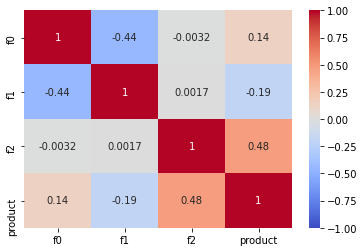

In [10]:
#Тепловая карта корреляции 
sns.heatmap(data_0.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm');



Мы ознакомились с первым представленным датафреймом. Всего в датафрейме 5 столбцов и 100 000 записей. Пропущенных значений и  дубликатов невыявлено.

In [11]:
#Изучаем второй датафрейм
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
#Проверяем количество явных дубликатов
data_1.duplicated().sum()

0

In [13]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [14]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [15]:
data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


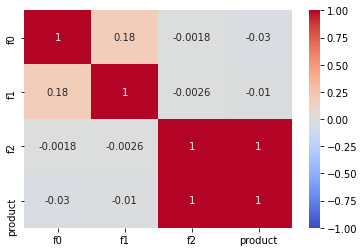

In [16]:
#Тепловая карта корреляции 
sns.heatmap(data_1.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm');

Мы ознакомились со вторым представленным датафреймом. Всего в датафрейме 5 столбцов и 100 000 записей. Пропущенных значений и дубликатов невыявлено.

In [17]:
#Изучаем третий датафрейм
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [18]:
#Проверяем количество явных дубликатов
data_2.duplicated().sum()

0

In [19]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [20]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [21]:
data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


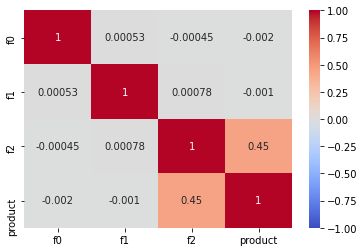

In [22]:
#Тепловая карта корреляции 
sns.heatmap(data_2.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm');

Мы ознакомились с третьим представленным датафреймом. Всего в датафрейме 5 столбцов и 100 000 записей. Пропущенных значений и дубликатов невыявлено.

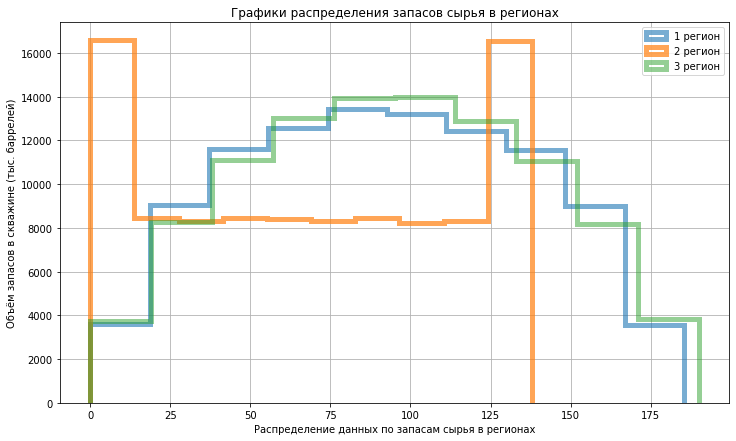

In [23]:
#Построим наглядный грфаик распределения сырья(product — объём запасов в скважине) в трех регионах
plt.title('Графики распределения запасов сырья в регионах')
ax=data_0['product'].plot(kind='hist',figsize=(12,7), grid=True, 
                          legend=True, alpha=0.6, histtype='step', 
                          linewidth=5, label='1 регион')

ax1=data_1['product'].plot(kind='hist',figsize=(12,7), grid=True, 
                           legend=True, alpha=0.7,histtype='step', 
                           linewidth=5, label='2 регион', ax=ax)

data_2['product'].plot(kind='hist',figsize=(12,7), grid=True, 
                       legend=True, alpha=0.5, histtype='step', 
                       linewidth=5, label='3 регион', ax=ax1)

plt.xlabel('Распределение данных по запасам сырья в регионах')
plt.ylabel('Объём запасов в скважине (тыс. баррелей)')
plt.show()

In [24]:
#Проверим каждый датафрейм на уникальные значения
data_0.nunique()

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [25]:
data_1.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

In [26]:
data_1['product'].unique()

array([  3.17910258,  26.95326103, 134.76630516, 137.94540774,
        84.03888568, 110.99214671,  53.90652206,   0.        ,
       107.81304413,  57.08562465,  30.13236361,  80.85978309])

In [27]:
data_1['product'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

In [28]:
data_2.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Во втором регионе выявлены 12 уникальных значений в столбце 'product', скорее всего это уникальные отдельные значения, которые встречаются только один раз в наборе данных, так как дубликатов  в данном датафрейме у нас не было выявлено. Данные уникальные значения не должны повлиять на результат, так как их количество слишком мало, но будем наблюдать в процессе. <br>
В остальных двух регионах (1 и 3) выбивающихся уникальных значений не выявлено.

In [29]:
#Проверяем на наличие дубликатов во всех трех датафреймах по столбцу 'id'
data_0.duplicated('id')

0        False
1        False
2        False
3        False
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Length: 100000, dtype: bool

In [30]:
data_1.duplicated('id')

0        False
1        False
2        False
3        False
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Length: 100000, dtype: bool

In [31]:
data_2.duplicated('id')

0        False
1        False
2        False
3        False
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Length: 100000, dtype: bool

Дубликатов в столбце с id - уникальным идентификатором скважины не выявлено во всех трех датафреймах.

### Вывод:
Мы ознакомились с тремя представленными регионами(датафреймами). В каждом датафрейме 5 столбцов и 100 000 записей. Пропущенных значений и дубликатов невыявлено.<br>

Как мы можем наблюдать на графике, второй регион сильно отличается от двух других регионов по распределению запасов сырья, у него есть сильно выбивающиеся значения, тогда как у первого и третьего регионов относительно похожие распределния. Так же можем заметить сильную корреляцию у второго региона с целевым признаком (0.99), что хорошо отразиться на предсказания модели линейной регресии.<br>

Целевым признаком является: <br>
• product — объём запасов в скважине (тыс. баррелей)<br>

Признаками являются:<br>
• id — уникальный идентификатор скважины<br>
• f0, f1, f2 — три признака точек

## Обучение и проверка модели

### Разбиваем данные на выборки

In [32]:
#Объявим две переменные 
#Удалим в признаках столбец id, так как данные этого столбца не повлияют на качество и результат обучения
#1 регион

features_0 = data_0.drop(['id', 'product'], axis=1)
target_0 = data_0['product']

#Разбиваем данные на обучающую и валидационную выборки в соотношении 75:25
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0, 
                                                                              test_size=0.25, random_state=12345)

#Проверяем размер выборки
print('Размер обучающей выборки 1 региона:')
print(features_train_0.shape)
print(target_train_0.shape)

print()

#Проверяем размер выборок
print('Размер валидационной выборки 1 региона:')
print(features_valid_0.shape)
print(target_valid_0.shape)

Размер обучающей выборки 1 региона:
(75000, 3)
(75000,)

Размер валидационной выборки 1 региона:
(25000, 3)
(25000,)


In [33]:
#2 регион
features_1 = data_1.drop(['id', 'product'], axis=1)
target_1 = data_1['product']

#Разбиваем данные на обучающую и валидационную выборки в соотношении 75:25
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, 
                                                                              test_size=0.25, random_state=12345)

#Проверяем размер выборки
print('Размер обучающей выборки 2 региона:')
print(features_train_1.shape)
print(target_train_1.shape)

print()

#Проверяем размер выборок
print('Размер валидационной выборки 2 региона:')
print(features_valid_1.shape)
print(target_valid_1.shape)

Размер обучающей выборки 2 региона:
(75000, 3)
(75000,)

Размер валидационной выборки 2 региона:
(25000, 3)
(25000,)


In [34]:
#3 регион
features_2 = data_2.drop(['id', 'product'], axis=1)
target_2 = data_2['product']

#Разбиваем данные на обучающую и валидационную выборки в соотношении 75:25
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, 
                                                                              test_size=0.25, random_state=12345)

#Проверяем размер выборки
print('Размер обучающей выборки 3 региона:')
print(features_train_2.shape)
print(target_train_2.shape)

print()

#Проверяем размер выборок
print('Размер валидационной выборки 3 региона:')
print(features_valid_2.shape)
print(target_valid_2.shape)

Размер обучающей выборки 3 региона:
(75000, 3)
(75000,)

Размер валидационной выборки 3 региона:
(25000, 3)
(25000,)


#### Вывод:
Мы разбили данные на обучающую и валидационную выборки в соотношении 75:25.

### Обучаем модель для каждого региона

In [35]:
#Обучим модель линейной регрессии на валидационной выборке, найдем RMSE и коэффициент детерминации (метрика R2)
#1 регион
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)
predictions_valid_0 = model_0.predict(features_valid_0) 
rmse_0 = mean_squared_error(target_valid_0, predictions_valid_0) ** 0.5 

print("RMSE модели линейной регрессии на валидационной выборке 1 региона:", rmse_0)
print("R2 на валидационной выборке 1 региона: ", model_0.score(features_valid_0, target_valid_0))

RMSE модели линейной регрессии на валидационной выборке 1 региона: 37.5794217150813
R2 на валидационной выборке 1 региона:  0.27994321524487786


In [36]:
#2 регион
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
predictions_valid_1 = model_1.predict(features_valid_1) 
rmse_1 = mean_squared_error(target_valid_1, predictions_valid_1) ** 0.5 

print("RMSE модели линейной регрессии на валидационной выборке 2 региона:", rmse_1)
print("R2 на валидационной выборке 2 региона: ", model_1.score(features_valid_1, target_valid_1))

RMSE модели линейной регрессии на валидационной выборке 2 региона: 0.893099286775617
R2 на валидационной выборке 2 региона:  0.9996233978805127


In [37]:
#3 регион
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
predictions_valid_2 = model_2.predict(features_valid_2) 
rmse_2 = mean_squared_error(target_valid_2, predictions_valid_2) ** 0.5 

print("RMSE модели линейной регрессии на валидационной выборке 3 региона:", rmse_2)
print("R2 на валидационной выборке 3 региона: ", model_2.score(features_valid_2, target_valid_2))

RMSE модели линейной регрессии на валидационной выборке 3 региона: 40.02970873393434
R2 на валидационной выборке 3 региона:  0.20524758386040443


#### Вывод:
Мы обучили модель линейной регрессии и сделали предсказания на валидационной выборке:<br>
Наилучшими показателями обладает 2 регион, RMSE модели линейной регрессии на валидационной выборке: 0.89, R2 на валидационной выборке: 1.0. <br>
Следующими хорошими показателями обладает 1 регион, при RMSE модели 37.58 и R2 0.28.<br>
Замыкающим стал регион № 3 с худшими показателями: RMSE модели 40.03 и R2 0.21.

### Сохраняем предсказания и правильные ответы на валидационной выборке

In [38]:
print('1 регион:\n Предсказания модели:','predictions_valid_0\n','Правильные ответы:','target_valid_0')
print()
print('2 регион:\n Предсказания модели:','predictions_valid_1\n','Правильные ответы:','target_valid_1')
print()
print('3 регион:\n Предсказания модели:','predictions_valid_2\n','Правильные ответы:','target_valid_2')
print()

1 регион:
 Предсказания модели: predictions_valid_0
 Правильные ответы: target_valid_0

2 регион:
 Предсказания модели: predictions_valid_1
 Правильные ответы: target_valid_1

3 регион:
 Предсказания модели: predictions_valid_2
 Правильные ответы: target_valid_2



#### Вывод:
Мы сохранили предсказания и правильные ответы на валидационной выборке и вывели на экран.

### Средний запас предсказанного сырья и RMSE модели

In [39]:
table_info = pd.DataFrame(index=['Средний запас предсказанного сырья', 'RMSE модели'], 
                          columns=['1 регион', '2 регион', '3 регион'])
table_info['1 регион'] = predictions_valid_0.mean(), rmse_0
table_info['2 регион'] = predictions_valid_1.mean(), rmse_1
table_info['3 регион'] = predictions_valid_2.mean(), rmse_2
table_info

,1 регион,2 регион,3 регион
Средний запас предсказанного сырья,92.592568,68.728547,94.965046
RMSE модели,37.579422,0.893099,40.029709


#### Вывод:
Мы напечатали на экране средний запас предсказанного сырья и RMSE модели для каждого региона.

### Вывод:
• Мы разбили данные на обучающую и валидационную выборки в соотношении 75:25 <br>
• Мы обучили модель линейной регрессии и сделали предсказания на валидационной выборке: <br>
Наилучшими показателями обладает 2 регион, RMSE модели линейной регрессии на валидационной выборке: 0.89, R2 на валидационной выборке: 1.0.<br>
Следующими хорошими показателями обладает 1 регион, при RMSE модели 37.58 и R2 0.28.<br>
Замыкающим стал 3 регион с худшими показателями: RMSE модели 40.03 и R2 0.21.  <br>

• Мы сохранили предсказания и правильные ответы на валидационной выборке и вывели на экран <br>
• Мы напечатали на экране средний запас предсказанного сырья и RMSE модели для каждого региона: <br>
Наибольший средний запас предсказанного сырья приходится на 3 и 1 регионы, 94.96 и 92.59 соответственно при RMSE моделей 40.03 и 37.58 соответственно, однако наилучшее RMSE у модели региона - 0.89 при среднем запасе предсказанного сырья в 68.73.

## Подготовка к расчёту прибыли

Условия: <br>
• При разведке региона необходимо исследовать 500 точек, из которых с помощью машинного обучения выбрать 200 лучших для разработки.<br>
• Бюджет на разработку скважин в регионе — 10 млрд рублей.<br>
• При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.<br>
• После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирать регион с наибольшей средней прибылью.<br>

### Ключевые значения для расчётов в отдельных переменных

In [40]:
#Бюджет на разработку скважин в регионе — 10 млрд рублей
BUDGET = 10_000_000_000

#200 точек для разработки
WELL_POINT = 200

#Доход от одного баррель сырья, тыс. рублей
PROFIT_ONE_BARREL = 450_000

#Вероятность убытков
LOSS_PROBABILITY = 2.5/100

#Считаем цену одной скважины
PRICE_ONE_WELL = BUDGET/WELL_POINT

print('Цена одной скважины (млн. рублей):', PRICE_ONE_WELL/1_000_000)

Цена одной скважины (млн. рублей): 50.0


In [41]:
#Средний запас сырья по регионам 
product_mean_0 = data_0['product'].mean()#.round(2)
product_mean_1 = data_1['product'].mean()#.round(2)
product_mean_2 = data_2['product'].mean()#.round(2)

print('Средний объём запасов в скважине (тыс. баррелей) в 1 регионе: ', product_mean_0.round(2))
print('Средний объём запасов в скважине (тыс. баррелей) в 2 регионе: ', product_mean_1.round(2))
print('Средний объём запасов в скважине (тыс. баррелей) в 3 регионе: ', product_mean_2.round(2))

Средний объём запасов в скважине (тыс. баррелей) в 1 регионе:  92.5
Средний объём запасов в скважине (тыс. баррелей) в 2 регионе:  68.83
Средний объём запасов в скважине (тыс. баррелей) в 3 регионе:  95.0


#### Вывод:
Мы сохранили все ключевые значения для расчётов в отдельных переменных.

### Рассчитываем достаточный объём сырья для безубыточной разработки новой скважины

In [42]:
breakeven_well = PRICE_ONE_WELL/PROFIT_ONE_BARREL
rounded = round(breakeven_well, 2)

print('Объем безубыточной одной скважины должен составлять не менее', rounded, 'тыс. баррелей')

Объем безубыточной одной скважины должен составлять не менее 111.11 тыс. баррелей


#### Вывод:
Мы рассчитали достаточный объём сырья для безубыточной разработки новой скважины и выяснили, что для безубыточной одной скважины объем должен составлять не менее 111.11 тыс. баррелей.

### Сравниваем полученный объём сырья со средним запасом в каждом регионе

In [43]:
data = pd.concat([pd.DataFrame([product_mean_0, product_mean_1, product_mean_2, breakeven_well], )])
data.columns=['Сравнение полученного объема сырья со средним запасом в каждом регионе, тыс. баррелей.']
data

,"Сравнение полученного объема сырья со средним запасом в каждом регионе, тыс. баррелей."
0,92.500000
1,68.825000
2,95.000000
3,111.111111


#### Вывод:
Мы сравнили полученный объем сырья со средним запасом в каждом регионе и, как мы можем наблюдать, ни в одном регионе нет достаточного объема сырья для безубыточной разработки новой скважины, однако можем отметить, что близкими по значению к отметке в 111.11 тыс. баррелей при котором происходит безубыточная разработка, являются первый и третий регионы, с объемами в 92.5 и 95.0 тыс. баррелей соответственно. Самым убыточным ябляется второй регион, средний объем сырья которого составляет 68.82 тыс. баррелей.

### Рассчитываем прибыль для каждого региона

In [44]:
#Прибыль 1 региона
data_0['profit']=(data_0['product']*(PROFIT_ONE_BARREL)).round(2)
data_0.head()

,id,f0,f1,f2,product,profit
0,txEyH,0.705745,-0.497823,1.221170,105.280062,47376027.83
1,2acmU,1.334711,-0.340164,4.365080,73.037750,32866987.62
2,409Wp,1.022732,0.151990,1.419926,85.265647,38369541.21
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,75879349.00
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,69316491.03


In [45]:
#Рассчитаем метрику ROI (от англ. return on investments, «возврат на инвестиции»), в % для 1 региона
data_0['ROI'] = ((data_0['profit'] - PRICE_ONE_WELL) / PRICE_ONE_WELL * 100).round(2)
data_0.head()

,id,f0,f1,f2,product,profit,ROI
0,txEyH,0.705745,-0.497823,1.221170,105.280062,47376027.83,-5.25
1,2acmU,1.334711,-0.340164,4.365080,73.037750,32866987.62,-34.27
2,409Wp,1.022732,0.151990,1.419926,85.265647,38369541.21,-23.26
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,75879349.00,51.76
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,69316491.03,38.63


In [46]:
data_0.describe()

,f0,f1,f2,product,profit,ROI
count,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000
mean,0.500419,0.250143,2.502647,92.500000,4.162500e+07,-16.750004
std,0.871832,0.504433,3.248248,44.288691,1.992991e+07,39.859815
min,-1.408605,-0.848218,-12.088328,0.000000,0.000000e+00,-100.000000
25%,-0.072580,-0.200881,0.287748,56.497507,2.542388e+07,-49.150000
50%,0.502360,0.250252,2.515969,91.849972,4.133249e+07,-17.335000
75%,1.073581,0.700646,4.715088,128.564089,5.785384e+07,15.710000
max,2.362331,1.343769,16.003790,185.364347,8.341396e+07,66.830000


Как мы видим на графике, в среднем прибыль (profit) у 1 региона равняется примерно ~ 41.5 млн. рублей. Средний ROI вложений пока не окупается и в среднем уходит в минус, то есть вложения пока не окупаются. 

In [47]:
#Прибыль 2 региона
data_1['profit']=(data_1['product']*(PROFIT_ONE_BARREL)).round(2)
data_1.head()

,id,f0,f1,f2,product,profit
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,1430596.16
1,62mP7,14.272088,-3.475083,0.999183,26.953261,12128967.46
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,60644837.32
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,62075433.48
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,60644837.32


In [48]:
#Рассчитаем метрику ROI (от англ. return on investments, «возврат на инвестиции»), в % для 2 региона
data_1['ROI'] = ((data_1['profit'] - PRICE_ONE_WELL) / PRICE_ONE_WELL * 100).round(2)
data_1.head()

,id,f0,f1,f2,product,profit,ROI
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,1430596.16,-97.14
1,62mP7,14.272088,-3.475083,0.999183,26.953261,12128967.46,-75.74
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,60644837.32,21.29
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,62075433.48,24.15
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,60644837.32,21.29


In [49]:
data_1.describe()

,f0,f1,f2,product,profit,ROI
count,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000,3.097125e+07,-38.057924
std,8.965932,5.119872,1.703572,45.944423,2.067499e+07,41.349090
min,-31.609576,-26.358598,-0.018144,0.000000,0.000000e+00,-100.000000
25%,-6.298551,-8.267985,1.000021,26.953261,1.212897e+07,-75.740000
50%,1.153055,-4.813172,2.011479,57.085625,2.568853e+07,-48.620000
75%,8.621015,-1.332816,3.999904,107.813044,4.851587e+07,-2.970000
max,29.421755,18.734063,5.019721,137.945408,6.207543e+07,24.150000


Как можно наблюдать на графике, в среднем прибыль (profit) у 2 региона равняется примерно ~ 30 млн. рублей. Средний ROI вложений пока не окупается и в среднем уходит в минус, то есть вложения в бизнес пока не окупаются.

In [50]:
#Прибыль 3 региона
data_2['profit']=(data_2['product']*(PROFIT_ONE_BARREL)).round(2)
data_2.head()

,id,f0,f1,f2,product,profit
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,12491402.95
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,25231363.48
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,28292359.52
3,q6cA6,2.236060,-0.553760,0.930038,114.572842,51557778.75
4,WPMUX,-0.515993,1.716266,5.899011,149.600746,67320335.66


In [51]:
#Рассчитаем метрику ROI (от англ. return on investments, «возврат на инвестиции»), в % для 1 региона
data_2['ROI'] = ((data_2['profit'] - PRICE_ONE_WELL) / PRICE_ONE_WELL * 100).round(2)
data_2.head()

,id,f0,f1,f2,product,profit,ROI
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,12491402.95,-75.02
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,25231363.48,-49.54
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,28292359.52,-43.42
3,q6cA6,2.236060,-0.553760,0.930038,114.572842,51557778.75,3.12
4,WPMUX,-0.515993,1.716266,5.899011,149.600746,67320335.66,34.64


In [52]:
data_2.describe()

,f0,f1,f2,product,profit,ROI
count,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000,4.275000e+07,-14.500000
std,1.732045,1.730417,3.473445,44.749921,2.013746e+07,40.274918
min,-8.760004,-7.084020,-11.970335,0.000000,0.000000e+00,-100.000000
25%,-1.162288,-1.174820,0.130359,59.450441,2.675270e+07,-46.490000
50%,0.009424,-0.009482,2.484236,94.925613,4.271653e+07,-14.570000
75%,1.158535,1.163678,4.858794,130.595027,5.876776e+07,17.540000
max,7.238262,7.844801,16.739402,190.029838,8.551343e+07,71.030000


Как можно заметить, в среднем прибыль (profit) у 3 региона равняется примерно ~ 42.7 млн. рублей. Средний ROI вложений пока не окупается и в среднем уходит в минус, то есть вложения в бизнес пока не окупаются.

### Вывод:
* Мы сохранили все ключевые значения для расчётов в отдельных переменных <br>
* Мы рассчитали достаточный объём сырья для безубыточной разработки новой скважины и выяснили, что для безубыточной одной скважины объем должен составлять не менее 111.11 тыс. баррелей <br>
* Мы сравнили полученный объем сырья со средним запасом в каждом регионе:<br>

-ни в одном регионе нет достаточного объема сырья для безубыточной разработки новой скважины; <br>

-близкими по значению к отметке в 111.11 тыс. баррелей при котором происходит безубыточная разработка, являются 1 и 3 регионы, с объемами в 92.5 и 95.0 тыс. баррелей соответственно;<br>

-самым убыточным является второй регион, средний объем сырья которого составляет 68.82 тыс. баррелей.<br>

* Мы рассчитали прибыль для каждого региона на основе предыдущих вычислений:<br>

-в среднем прибыль (profit) у 1 региона равняется примерно ~ 41.5 млн. рублей. Средний ROI вложений пока не окупается и в среднем уходит в минус, то есть вложения пока не окупаются;<br>

-в среднем прибыль у 2 региона равняется примерно ~ 30 млн. рублей. Средний ROI вложений пока не окупается и в среднем уходит в минус, то есть вложения в бизнес пока не окупаются;<br>

-в среднем прибыль у 3 региона равняется примерно ~ 42.7 млн. рублей. Средний ROI вложений пока не окупается и в среднем уходит в минус, то есть вложения в бизнес пока не окупаются.<br>

На основе полученных данных, можно сказать, что прибыльными для бизнеса являются 1 и 3 регионы, они близки по значениям к безубыточной разработке, а так же являются самыми прибыльными регионами, лидером выступает 3 регион с объемом разработки 95.0 тыс. баррелей и прыблью в ~ 42.7 млн. рублей.

## Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели 

### Выбираем скважины с максимальными значениями предсказаний

In [53]:
#Привяжем индексы скважин к предсказаниям модели и отсорируем список по убыванию
predict_sorted_0 = pd.Series(predictions_valid_0, index=target_valid_0.index).sort_values(ascending=False)
predict_sorted_0

#Выберем 200 точек с максимальными предсказаниями 
top_of_max_0 = predict_sorted_0[:200]
top_of_max_0

93073    180.180713
46784    176.252213
78948    175.850623
43388    175.658429
6496     173.299686
            ...    
30488    148.507064
98799    148.481767
53840    148.476498
4638     148.436761
75908    148.365941
Length: 200, dtype: float64

#### Вывод:
Мы отобрали 200 скважин с максимальными значениями предсказаний.

### Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям

In [54]:
#Находим суммарный объем 200 точек с максимальными предсказаниями 
top_of_max_0_sum = top_of_max_0.sum()
print('Суммарный объем запасов в 200 лучших скважинах составляет:', top_of_max_0_sum.round(2), 'тыс. баррелей')

Суммарный объем запасов в 200 лучших скважинах составляет: 31102.33 тыс. баррелей


#### Вывод:
Мы просуммировали целевое значение объёма сырья, соответствующее предсказаниям: <br>
* Суммарный объем запасов в 200 лучших скважинах составляет: 31102.33 тыс. баррелей.

### Рассчитаем прибыль для полученного объёма сырья

In [55]:
#Рассчитаем прибыль для полученного объёма сырья
profit_total_0= (top_of_max_0_sum * PROFIT_ONE_BARREL) - BUDGET
print('Общая прибыль для полученного объёма сырья составляет:', profit_total_0.round(2), 'млрд. рублей')

Общая прибыль для полученного объёма сырья составляет: 3996048877.47 млрд. рублей


In [56]:
#Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели
def total_of_profit(predict, target, count):
    predict_sorted = pd.Series(predict, index=target.index).sort_values(ascending=False)
    top_of_max = predict_sorted[:count].sum()
    profit_total=(top_of_max * PROFIT_ONE_BARREL) - BUDGET
    print('Суммарный объем запасов в 200 лучших скважинах составляет:', top_of_max.round(2), 'тыс. баррелей')
    print('Общая прибыль для полученного объёма сырья составляет:', profit_total.round(2), 'млрд. рублей')

In [57]:
#Прибыль 1 региона
total_of_profit(predictions_valid_0, target_valid_0, 200)

Суммарный объем запасов в 200 лучших скважинах составляет: 31102.33 тыс. баррелей
Общая прибыль для полученного объёма сырья составляет: 3996048877.47 млрд. рублей


In [58]:
#Прибыль 2 региона
total_of_profit(predictions_valid_1, target_valid_1, 200)

Суммарный объем запасов в 200 лучших скважинах составляет: 27746.03 тыс. баррелей
Общая прибыль для полученного объёма сырья составляет: 2485712051.97 млрд. рублей


In [59]:
#Прибыль 3 региона
total_of_profit(predictions_valid_2, target_valid_2, 200)

Суммарный объем запасов в 200 лучших скважинах составляет: 29603.9 тыс. баррелей
Общая прибыль для полученного объёма сырья составляет: 3321754396.24 млрд. рублей


#### Вывод:
Мы рассчитали прибыль для полученного объёма сырья и написали функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

### Вывод:
* Мы отобрали 200 скважин с максимальными значениями предсказаний<br>
* Мы просуммировали целевое значение объёма сырья, соответствующее предсказаниям<br>

* Мы рассчитали прибыль для полученного объёма сырья<br>
* Написали функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:<br>

-1 регион: <br>
Суммарный объем запасов в 200 лучших скважинах составляет: 31102.33 тыс. баррелей<br>
Общая прибыль для полученного объёма сырья составляет: 4 млрд. рублей<br>

-2 регион:<br>
Суммарный объем запасов в 200 лучших скважинах составляет: 27746.03 тыс. баррелей<br>
Общая прибыль для полученного объёма сырья составляет: 2.5 млрд. рублей<br>

-3 регион:<br>
Суммарный объем запасов в 200 лучших скважинах составляет: 29603.9 тыс. баррелей<br>
Общая прибыль для полученного объёма сырья составляет: 3.3 млрд. рублей<br>

Как мы можем наблюдать, лидерами по суммарному объему запасов в 200  лучших скважинах и общей прибыли для полученного объма сырья выступают 1 и 3 регионы, с показателями в 31102.33 тыс. баррелей и 29603.9 тыс. баррелей, 4 млрд. рублей и 3.3 млрд. руюлей соответственно. 

## Расчёт прибыли и рисков 

In [60]:
def profit(predict, target, count):
    predict_sorted = pd.Series(predict).sort_values(ascending=False)
    target_sorted = target[predict_sorted.index][:count]
    product = target_sorted.sum()
    revenue = product * PROFIT_ONE_BARREL
    return revenue - BUDGET

In [61]:
#Применяем технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли
#и находим айдите среднюю прибыль, 95%-й доверительный интервал и риск убытков
#Убыток — это отрицательная прибыль
def bootstrap(target, predict):
    values = []
    count=0
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)
    
    for i in tqdm(range(1000)):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        probs_subsample = predict_e[target_subsample.index]
        values.append(profit(probs_subsample, target_subsample, 200))
        
    for i in values:
        if i < 0:
            count +=1
            
    values = pd.Series(values)
    mean = values.mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    
    plt.title('Распределение прибыли')
    values.plot(kind="hist", grid=True, figsize=(10, 5))
    plt.xlabel('Прибыль, млрд. рублей')
    plt.ylabel('Объем')
    plt.show()
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    print("Средняя прибыль: {:.2f} млн.руб".format(mean/1000000))
    print('С вероятностью 95% прибыль в данном регионе будет составлять от: {:.2f} млн.руб до: {:.2f} млн.руб'.format((lower/1000000),(upper/1000000)))
    print("95%-ый доверительный интервал: от {:.2f} млн.руб до {:.2f} млн.руб". format((confidence_interval[0]/1000000),(confidence_interval[1]/1000000)))
    print ('Процент вероятности убытка в данном регионе составит {:.1%}'.format(count/1000))

  0%|          | 0/1000 [00:00<?, ?it/s]

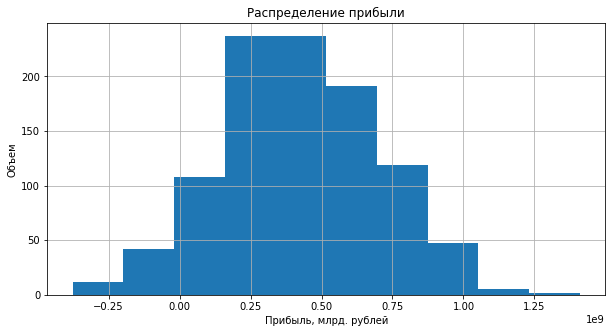

Средняя прибыль: 425.94 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -102.09 млн.руб до: 947.98 млн.руб
95%-ый доверительный интервал: от 408.73 млн.руб до 443.14 млн.руб
Процент вероятности убытка в данном регионе составит 6.0%


In [62]:
#Расчёт прибыли и рисков 1 региона
bootstrap(target_valid_0, predictions_valid_0)

  0%|          | 0/1000 [00:00<?, ?it/s]

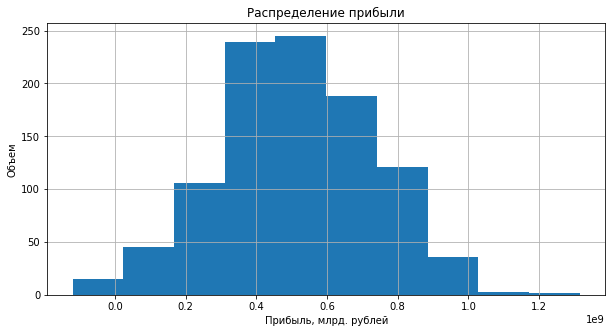

Средняя прибыль: 515.22 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: 68.87 млн.руб до: 931.55 млн.руб
95%-ый доверительный интервал: от 501.62 млн.руб до 528.82 млн.руб
Процент вероятности убытка в данном регионе составит 1.0%


In [63]:
#Расчёт прибыли и рисков 2 региона
bootstrap(target_valid_1, predictions_valid_1)

  0%|          | 0/1000 [00:00<?, ?it/s]

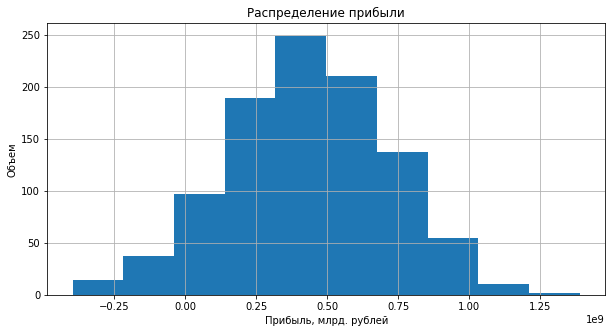

Средняя прибыль: 435.01 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -128.88 млн.руб до: 969.71 млн.руб
95%-ый доверительный интервал: от 417.45 млн.руб до 452.56 млн.руб
Процент вероятности убытка в данном регионе составит 6.4%


In [64]:
#Расчёт прибыли и рисков 3 региона
bootstrap(target_valid_2, predictions_valid_2)

In [65]:
#Напечатаем на экране основные характеристики для каждого региона 
#и выберем регион с наименьшей вероятностью убытков
table_info_2 = pd.DataFrame(index=['Средняя прибыль в регионе, млн. руб.', 'Суммарный объем запасов, тыс. бар.', 'Вероятность убытка, %'], 
                          columns=['1 регион', '2 регион', '3 регион'])
table_info_2['1 регион'] = '425.94', '31102.33', '6.0'
table_info_2['2 регион'] = '515.22', '27746.03', '1.0'
table_info_2['3 регион'] = '435.01', '29603.9', '6.4'
table_info_2

,1 регион,2 регион,3 регион
"Средняя прибыль в регионе, млн. руб.",425.94,515.22,435.01
"Суммарный объем запасов, тыс. бар.",31102.33,27746.03,29603.9
"Вероятность убытка, %",6.0,1.0,6.4


#### Вывод:
Абсолютным лидером, у которого вероятность убытков составляет менее 2.5% и средняя прибыль приходится самой большой среди двух других регионов, является 2 регион с вероятностью убытков в 1 %, средней прибылью в регионе 515.22 млн. рублей и суммарным объемом запасов сырья 27746.03 тыс. баррелей.

### Вывод:
* Мы посчитали риски и прибыль для каждого региона <br>
* Применили технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли<br>
* Нашли среднюю прибыль, 95%-й доверительный интервал и риск убытков<br>
* Предложили регион для разработки скважин и обосновали выбор:<br>

Благодаря технике бутстреп, мы выявили лидера и нашли регион, где можно бурить новую скважину с минимальными потерями и высокой прибылью, данным регионом является 2 регион, с вероятностью убытков в 1 %, средней прибылью в регионе 515.22 млн. рублей и суммарным объемом запасов сырья 27746.03 тыс. баррелей. 

## Общий вывод:
1. Мы ознакомились с представленным датафреймом и провели предобработку данных <br>
2. Мы разбили данные на обучающую и валидационную выборки в соотношении 75:25 <br>
3. Мы обучили модель линейной регрессии и сделали предсказания на валидационной выборке: <br>
* Наилучшими показателями обладает 2 регион, RMSE модели линейной регрессии на валидационной выборке: 0.89, R2 на валидационной выборке: 1.0. <br>

* Следующими хорошими показателями обладает 1 регион, при RMSE модели 37.58 и R2 0.28. <br>

* Замыкающим стал 3 регион с худшими показателями: RMSE модели 40.03 и R2 0.21. <br>


4. Мы сохранили предсказания и правильные ответы на валидационной выборке и вывели на экран <br>
5. Мы напечатали на экране средний запас предсказанного сырья и RMSE модели для каждого региона: <br> 
* Наибольший средний запас предсказанного сырья приходится на 3 и 1 регионы, 94.96 и 92.59 соответственно при RMSE моделей 40.03 и 37.58 соответственно, однако наилучшее RMSE у модели региона - 0.89 при среднем запасе предсказанного сырья в 68.73. <br>


6. Мы сохранили все ключевые значения для расчётов в отдельных переменных <br>
7. Мы рассчитали достаточный объём сырья для безубыточной разработки новой скважины и выяснили, что для безубыточной одной скважины объем должен составлять не менее 111.11 тыс. баррелей <br>
8. Мы сравнили полученный объем сырья со средним запасом в каждом регионе: <br>
* ни в одном регионе нет достаточного объема сырья для безубыточной разработки новой скважины; <br>

* близкими по значению к отметке в 111.11 тыс. баррелей при котором происходит безубыточная разработка, являются 1 и 3 регионы, с объемами в 92.5 и 95.0 тыс. баррелей соответственно; <br>

* самым убыточным является второй регион, средний объем сырья которого составляет 68.82 тыс. баррелей. <br>


9. Мы рассчитали прибыль для каждого региона на основе предыдущих вычислений: <br>
* в среднем прибыль (profit) у 1 региона равняется примерно ~ 41.5 млн. рублей. Средний ROI вложений пока не окупается и в среднем уходит в минус, то есть вложения пока не окупаются; <br>

* в среднем прибыль у 2 региона равняется примерно ~ 30 млн. рублей. Средний ROI вложений пока не окупается и в среднем уходит в минус, то есть вложения в бизнес пока не окупаются; <br>

* в среднем прибыль у 3 региона равняется примерно ~ 42.7 млн. рублей. Средний ROI вложений пока не окупается и в среднем уходит в минус, то есть вложения в бизнес пока не окупаются. <br>


10.	Мы отобрали 200 скважин с максимальными значениями предсказаний <br>
11.	Мы просуммировали целевое значение объёма сырья, соответствующее предсказаниям <br>
12.	Мы рассчитали прибыль для полученного объёма сырья <br>
13.	Написали функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели: <br>
* 1 регион: <br>
Суммарный объем запасов в 200 лучших скважинах составляет: 31102.33 тыс. баррелей <br>
Общая прибыль для полученного объёма сырья составляет: 4 млрд. рублей <br>

* 2 регион: <br>
Суммарный объем запасов в 200 лучших скважинах составляет: 27746.03 тыс. баррелей <br>
Общая прибыль для полученного объёма сырья составляет: 2.5 млрд. рублей <br>

* 3 регион: <br>
Суммарный объем запасов в 200 лучших скважинах составляет: 29603.9 тыс. баррелей <br>
Общая прибыль для полученного объёма сырья составляет: 3.3 млрд. рублей <br>


14. Мы посчитали риски и прибыль для каждого региона <br>
15. Применили технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли <br>
16. Нашли среднюю прибыль, 95%-й доверительный интервал и риск убытков <br>
17. Предложили регион для разработки скважин и обосновали выбор: <br>
* лидером для бурения новой скважины выступает 2 регион. <br>


Рекомендации: <br>
2 регион рекомендуется для места бурения новой скважины, так как имеет хорошие показатели прибыли и объема сырья, а так же имея вероятность в убытке 1 %, что немаловажно. То есть с большей вроятностью новая скважина окупит себя или начнет приносить прибыль. Так же в процессе обучения модели линейной регрессии и предсказаний на валидационной выборке, 2 регион обладал наилучшими показателями и являлся абсолютным лидером: RMSE модели линейной регрессии на валидационной выборке 0.89, R2 на валидационной выборке 1.0.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован